In [1]:
import h5py
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import classification_report
from torchvision.models import ResNet18_Weights
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)

# Reproducibility
np.random.seed(595)
torch.manual_seed(595)
class H5Dataset(Dataset):
    def __init__(self, path, x_key, y_key, idx=None, transform=None):
        super().__init__()
        self.path = path
        self.x_key = x_key
        self.y_key = y_key
        self.transform = transform
        with h5py.File(path, "r") as f:
            x = np.array(f[x_key][:])  
            y = np.array(f[y_key][:])   
        self.x = x
        self.y = y.reshape(-1)
        if idx is None:
            self.idx = np.arange(self.x.shape[0])
        else:
            self.idx = np.array(idx)

    def __len__(self):
        return len(self.idx)

    def __getitem__(self, i):
        j = int(self.idx[i])
        img = self.x[j]           
        lab = float(self.y[j])     
        img = Image.fromarray(img.astype(np.uint8))
        if self.transform is not None:
            img = self.transform(img)
        else:
            img = transforms.ToTensor()(img)

        lab = torch.tensor(lab, dtype=torch.float32)
        return img, lab, j


# Image transform 
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

def get_model(lr=1e-5):
    weights = ResNet18_Weights.DEFAULT
    model = models.resnet18(weights=weights)
    in_f = model.fc.in_features
    model.fc = nn.Linear(in_f, 1)
    crit = nn.BCEWithLogitsLoss()
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    sch = torch.optim.lr_scheduler.StepLR(opt, step_size=5, gamma=1e-6)
    model = model.to(device)
    return model, crit, opt, sch

# Standard training loop.
def train(model, crit, opt, sch, loader, epochs=10):
    model.train()
    for ep in range(epochs):
        loss_sum = 0.0
        correct = 0
        n = 0
        for x_batch, y_batch, _ in loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device).view(-1, 1)
            opt.zero_grad()
            out = model(x_batch)
            loss = crit(out, y_batch)
            loss.backward()
            opt.step()
            loss_sum += loss.item() * x_batch.size(0)
            pred = (torch.sigmoid(out) >= 0.5).float()
            correct += (pred == y_batch).sum().item()
            n += y_batch.size(0)
        sch.step()
        ep_loss = loss_sum / n
        ep_acc = correct / n
        print(f"Epoch [{ep+1}/{epochs}]  Loss: {ep_loss:.4f}  Acc: {ep_acc:.4f}")

def evaluate(model, loader):
    model.eval()
    correct = 0
    n = 0
    y_true = []
    y_pred = []
    err_idx = []
    err_img = []
    err_y = []
    err_yhat = []
    with torch.no_grad():
        for x_batch, y_batch, idx_batch in loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device).view(-1, 1)
            out = model(x_batch)
            prob = torch.sigmoid(out)
            pred = (prob >= 0.5).float()
            correct += (pred == y_batch).sum().item()
            n += y_batch.size(0)
            y_true.extend(y_batch.cpu().view(-1).numpy().astype(int).tolist())
            y_pred.extend(pred.cpu().view(-1).numpy().astype(int).tolist())
            mismatch = pred.cpu().view(-1) != y_batch.cpu().view(-1)
            for img, idx, yt, yp, mis in zip(
                x_batch.cpu(), idx_batch, y_batch.cpu().view(-1),
                pred.cpu().view(-1), mismatch
            ):
                if mis:
                    err_idx.append(int(idx))
                    err_img.append(img)
                    err_y.append(int(yt.item()))
                    err_yhat.append(int(yp.item()))
    acc = correct / n
    print(f"Accuracy: {acc:.4f}")
    print("\nClassification report:\n")
    print(classification_report(
        y_true, y_pred, target_names=["non-cat", "cat"]
    ))
    return acc, err_idx, err_img, err_y, err_yhat


def show_errors(err_idx, err_img, err_y, err_yhat, k=4):
    k = min(k, len(err_idx))
    if k == 0:
        print("No misclassified samples.")
        return
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    plt.figure(figsize=(4 * k, 4))
    for i in range(k):
        img_t = err_img[i].clone().numpy()    
        img = np.transpose(img_t, (1, 2, 0))     
        img = std * img + mean
        img = np.clip(img, 0, 1)
        plt.subplot(1, k, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"idx={err_idx[i]}\ntrue={err_y[i]}, pred={err_yhat[i]}")
    plt.tight_layout()
    plt.show()

Using device: cpu


In [2]:
train_path = r"C:\SelfAPP\train_catvnoncat.h5"
x_key = "train_set_x"
y_key = "train_set_y"
n_total = 209
last_digit = 8 # last digit of ID
n_train = 160 + last_digit
assert n_train <= n_total, "160 + last_digit must be <= 209"
idx_train = np.arange(n_train)
idx_test = np.arange(n_train, n_total)
print("New train size:", len(idx_train))
print("New test size :", len(idx_test))

train_ds = H5Dataset(
    path=train_path,
    x_key=x_key,
    y_key=y_key,
    idx=idx_train,
    transform=transform
)

test_ds = H5Dataset(
    path=train_path,
    x_key=x_key,
    y_key=y_key,
    idx=idx_test,
    transform=transform
)

batch_size = 32

train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
)

test_loader = DataLoader(
    test_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
)

print("New train dataset length:", len(train_ds))
print("New test  dataset length:", len(test_ds))

New train size: 168
New test size : 41
New train dataset length: 168
New test  dataset length: 41


In [3]:
model, crit, opt, sch = get_model(lr=1e-5)
train(
    model, crit, opt, sch,
    train_loader, epochs=10
)

Epoch [1/10]  Loss: 0.8999  Acc: 0.3929
Epoch [2/10]  Loss: 0.7262  Acc: 0.4405
Epoch [3/10]  Loss: 0.6029  Acc: 0.5417
Epoch [4/10]  Loss: 0.4858  Acc: 0.6964
Epoch [5/10]  Loss: 0.3967  Acc: 0.8274
Epoch [6/10]  Loss: 0.3357  Acc: 0.9048
Epoch [7/10]  Loss: 0.3655  Acc: 0.8631
Epoch [8/10]  Loss: 0.3524  Acc: 0.8750
Epoch [9/10]  Loss: 0.3655  Acc: 0.8452
Epoch [10/10]  Loss: 0.3373  Acc: 0.8869



Evaluate on NEW TRAIN SET
Accuracy: 0.9167

Classification report:

              precision    recall  f1-score   support

     non-cat       1.00      0.87      0.93       108
         cat       0.81      1.00      0.90        60

    accuracy                           0.92       168
   macro avg       0.91      0.94      0.91       168
weighted avg       0.93      0.92      0.92       168


Evaluate on NEW TEST SET
Accuracy: 0.6829

Classification report:

              precision    recall  f1-score   support

     non-cat       1.00      0.55      0.71        29
         cat       0.48      1.00      0.65        12

    accuracy                           0.68        41
   macro avg       0.74      0.78      0.68        41
weighted avg       0.85      0.68      0.69        41


Train accuracy (new split): 0.9166666666666666
Test  accuracy (new split): 0.6829268292682927

Misclassified indices on NEW test set (indices refer to the ORIGINAL TRAIN set):
[168, 180, 184, 187, 191, 195, 1

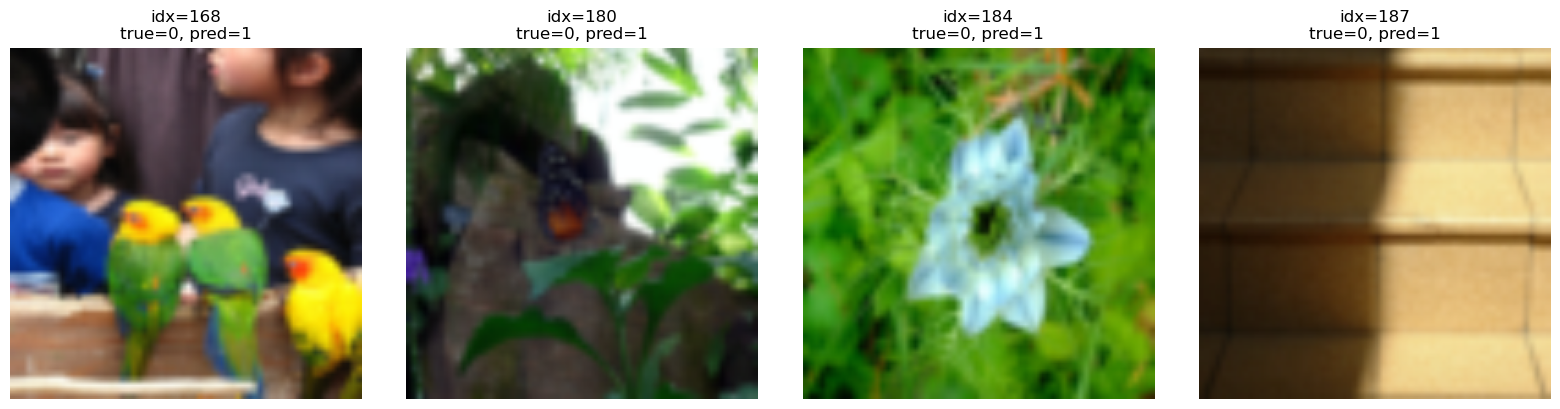

In [4]:
print("\nEvaluate on NEW TRAIN SET")
train_acc, _, _, _, _ = evaluate(model, train_loader)
print("\nEvaluate on NEW TEST SET")
test_acc, err_idx, err_img, err_y, err_yhat = evaluate(model, test_loader)
print("\nTrain accuracy (new split):", train_acc)
print("Test  accuracy (new split):", test_acc)
print("\nMisclassified indices on NEW test set "
      "(indices refer to the ORIGINAL TRAIN set):")
print(err_idx)
show_errors(err_idx, err_img, err_y, err_yhat, k=4)